Fitting 10 folds for each of 32 candidates, totalling 320 fits


<ipython-input-1-ae9bf78abd08>:47: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Epoch 1/10
58/58 [==============================] - 5s 26ms/step - loss: 0.2403 - val_loss: 0.6563
Epoch 2/10
58/58 [==============================] - 1s 17ms/step - loss: 0.0680 - val_loss: 1.9847
Epoch 3/10
58/58 [==============================] - 1s 16ms/step - loss: 0.0664 - val_loss: 0.6635
Epoch 4/10
58/58 [==============================] - 1s 16ms/step - loss: 0.0619 - val_loss: 0.7638
Epoch 5/10
58/58 [==============================] - 1s 16ms/step - loss: 0.0430 - val_loss: 0.2167
Epoch 6/10
58/58 [==============================] - 1s 17ms/step - loss: 0.0366 - val_loss: 0.2041
Epoch 7/10
58/58 [==============================] - 1s 24ms/step - loss: 0.0363 - val_loss: 0.1054
Epoch 8/10
58/58 [==============================] - 1s 25ms/step - loss: 0.0347 - val_loss: 0.1296
Epoch 9/10
58/58 [==============================] - 1s 21ms/step - loss: 0.0344 - val_loss: 0.0673
Epoch 10/10
58/58 [==============================] - 1s 16ms/step - loss: 0.0323 - val_loss: 0.0964
Model: "s

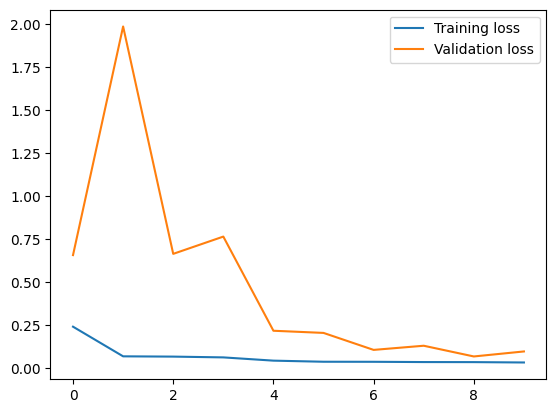

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

df = pd.read_csv('MANU_3 years.csv')

train_dates = pd.to_datetime(df['Date'])

cols = list(df)[1:6]

df_for_training = df[cols].astype(float)

scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

trainX = []
trainY = []

n_future = 1
n_past = 14

for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

def create_model(optimizer='adam', lstm1_units=64, lstm2_units=32, dropout_rate=0.2, batch_size=None):
    model = Sequential()
    model.add(LSTM(lstm1_units, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(LSTM(lstm2_units, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(trainY.shape[1]))
    model.compile(optimizer=optimizer, loss='mse')
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)

param_grid = {
    'epochs': [5, 10],
    'batch_size': [8, 16],
    'optimizer': ['adam'],
    'lstm1_units': [32, 64],
    'lstm2_units': [16, 32],
    'dropout_rate': [0.1, 0.2]
}
tscv = TimeSeriesSplit(n_splits=10)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, verbose=2, n_jobs=-1)

grid_result = grid.fit(trainX, trainY)

best_params = grid_result.best_params_.copy()
best_params.pop('epochs')
best_params.pop('batch_size')

best_model = create_model(**best_params)

history = best_model.fit(trainX, trainY, epochs=grid_result.best_params_['epochs'], batch_size=grid_result.best_params_['batch_size'], validation_split=0.1, verbose=1)

best_model.summary()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()




1/1 [==============================] - 1s 573ms/step
          Date       Open
0   2023-03-01  22.146971
1   2023-03-02  22.103441
2   2023-03-03  22.088015
3   2023-03-06  22.145493
4   2023-03-07  22.387344
5   2023-03-08  22.250851
6   2023-03-09  21.979593
7   2023-03-10  22.159868
8   2023-03-13  22.138744
9   2023-03-14  21.964867
10  2023-03-15  21.929831
11  2023-03-16  21.849842
12  2023-03-17  21.767410
13  2023-03-20  21.748493
14  2023-03-21  21.397058


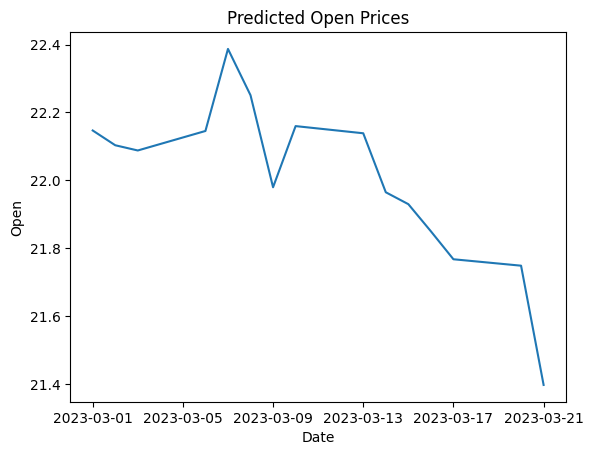

In [2]:
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

n_past = 14
n_days_for_prediction = 15

# Find the index of the date 2/27/2023 in the train_dates DataFrame
start_date_index = train_dates[train_dates == '2023-02-27'].index[0]

# Get the prediction period dates
predict_period_dates = pd.date_range('2023-03-01', periods=n_days_for_prediction, freq=us_bd)

# Prepare the input for prediction
n_days_for_prediction_input = len(predict_period_dates)
prediction_input = trainX[-n_days_for_prediction_input-n_past:-n_past]

# Make prediction
prediction = best_model.predict(prediction_input)  # shape = (n, 1) where n is the n_days_for_prediction_input

#Perform inverse transformation to rescale back to original range
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

# Convert timestamp to date
forecast_dates = [d.date() for d in predict_period_dates]

# Create dataframe with predicted values
df_forecast = pd.DataFrame({'Date': forecast_dates, 'Open': y_pred_future})
print(df_forecast)
# Plot the predicted Open prices against dates
sns.lineplot(data=df_forecast, x="Date", y="Open")
plt.xlabel("Date")
plt.ylabel("Open")
plt.title("Predicted Open Prices")
plt.show()


In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Get training and validation predictions
y_train_pred = best_model.predict(trainX)
y_val_pred = best_model.predict(trainX[-int(0.1 * len(trainX)):])

# Perform inverse transformation to rescale back to original range
y_train_pred_copies = np.repeat(y_train_pred, df_for_training.shape[1], axis=-1)
y_train_pred_inv = scaler.inverse_transform(y_train_pred_copies)[:, 0]

y_val_pred_copies = np.repeat(y_val_pred, df_for_training.shape[1], axis=-1)
y_val_pred_inv = scaler.inverse_transform(y_val_pred_copies)[:, 0]

# Compute error metrics
mse_train = mean_squared_error(trainY[:-int(0.1 * len(trainY))], y_train_pred[:-int(0.1 * len(trainY))])
mse_val = mean_squared_error(trainY[-int(0.1 * len(trainY)):], y_val_pred)

mae_train = mean_absolute_error(trainY[:-int(0.1 * len(trainY))], y_train_pred[:-int(0.1 * len(trainY))])
mae_val = mean_absolute_error(trainY[-int(0.1 * len(trainY)):], y_val_pred)

rmse_train = sqrt(mse_train)
rmse_val = sqrt(mse_val)

mape_train = mean_absolute_percentage_error(trainY[:-int(0.1 * len(trainY))], y_train_pred[:-int(0.1 * len(trainY))])
mape_val = mean_absolute_percentage_error(trainY[-int(0.1 * len(trainY)):], y_val_pred)

# Create DataFrame
error_metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'RMSE', 'MAPE'],
    'Training': [mse_train, mae_train, rmse_train, mape_train],
    'Validation': [mse_val, mae_val, rmse_val, mape_val]
})

print(error_metrics_df)


4/4 [==============================] - 0s 7ms/step
  Metric   Training  Validation
0    MSE   0.012314    0.097355
1    MAE   0.080474    0.234138
2   RMSE   0.110968    0.312018
3   MAPE  61.908112   58.567457
